# BLSTM Model with Attention <br/>for Aspect-Level Sentiment Analysis

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!cp /gdrive/My\ Drive/{train.csv,embeddings.p,test_public.csv} .
!pip install -q pydot > /dev/null
!pip install graphviz jieba > /dev/null
!apt-get install graphviz > /dev/null

In [1]:
import jieba
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Softmax, Flatten, Dropout
from keras.layers import Bidirectional, Dense, Dot, Lambda, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

jieba.setLogLevel(20)

Using TensorFlow backend.


## 1 Data

Model input is a sentence (here a user comment), and output is a 40-dimensional vector representing the probability of 4 sentiment polarities for 10 aspects.

Sentiment polarities are "无关" (Irrelevant), 0 (Neutral), 1 (Positive), -1 (Negative).

In [0]:
senti_label_id  = {'无关': 0, 0: 1, 1: 2, -1: 3}
aspect_label_id = {'动力': 0, '价格': 1, '内饰': 2, '配置': 3, '安全性': 4, 
                   '外观': 5, '操控': 6, '油耗': 7, '空间': 8, '舒适性': 9}

N_SENTI, N_ASPECT = len(senti_label_id), len(aspect_label_id)

Zero-padding sentence for batch training.

In [0]:
Tx = 256

Load word embedding and traing data.

In [0]:
word_index, embedding_matrix = pickle.load(open('embeddings.p', 'rb' ))

In [0]:
def preprocess(text):
    """Sentence tokenization."""
    words = jieba.lcut_for_search(text)
    return [word_index[w] for w in words if w in word_index.keys()]

def get_training_data():
    """Format training data to model style."""
    X_y = defaultdict(lambda: [1, 0, 0, 0] * N_ASPECT)
    for e in pd.read_csv('train.csv').itertuples():
        i = aspect_label_id[e.subject] * N_SENTI
        X_y[e.content][i] = 0
        X_y[e.content][i + senti_label_id[e.sentiment_value]] = 1
    X, y = [], []
    for content, senti in X_y.items():
        X.append(preprocess(content))
        y.append(senti)
    return pad_sequences(X, maxlen=Tx), np.array(y)

Split to training, validation and test sets.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    *get_training_data(), test_size=0.2, random_state=666)
X_test, X_val, y_test, y_val = train_test_split(
    X_val, y_val, test_size=0.5, random_state=233)

print(len(y_train), len(y_val), len(y_test))

8523 1066 1065


## 2 Model

### 2.1 Architecture

In [0]:
n_a = 100
drop_rate = 0.5
reg_rate = 0.001

def model():
    sen = Input(shape=(Tx,), name='Sentence')
    asp = Lambda(lambda x: tf.constant([[word_index[w] for w in
                                         ['动力', '价格', '内饰', '配置',
                                          '安全', '外观', '操控', '油耗',
                                          '空间', '舒适']]]),
                 name='Aspect')([])
    
    bs = K.shape(sen)[0]
    l = regularizers.l2(reg_rate)
    E = Embedding(*embedding_matrix.shape, trainable=False,
                  embeddings_initializer=Constant(embedding_matrix),
                  name='WordVec')
    
    asen = Bidirectional(LSTM(n_a, return_sequences=True, dropout=drop_rate,
                              recurrent_dropout=drop_rate),
                         name='BLSTM-Sen')(E(sen))
    
    aasp = Bidirectional(LSTM(n_a, return_sequences=True, dropout=drop_rate,
                              recurrent_dropout=drop_rate),
                         name='BLSTM-Asp')(E(asp))
    aasp = Lambda(lambda a: tf.reshape(tf.tile(tf.reshape(a, (-1,)), [bs]),
                                       (bs, 10, 200)),
                  name='Repeat')(aasp)
    
    X = Dot(-1, name='Project')([asen, aasp])
    a = Softmax(1, name='Within-Aspect')(X)
    
    X = Dot(1, name='Attention')([a, asen])
    
    X = Dropout(drop_rate, name='Dropout')(X)
    X = Flatten(name='Flatten')(X)
    
    X = Dense(512, kernel_regularizer=l, name='Asp-Senti-Clf-1')(X)
    X = LeakyReLU(0.01, name='LeakyReLU')(X)
    
    X = Dense(40, kernel_regularizer=l, name='Asp-Senti-Clf-2')(X)
    X = Lambda(lambda x: tf.reshape(K.softmax(tf.reshape(x, (bs, 10, 4))),
                                    (bs, 40)), name='Aspect-Softmax')(X)
    
    return Model(inputs=sen, outputs=X)

model = model()

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sentence (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
Aspect (Lambda)                 (1, 10)              0                                            
__________________________________________________________________________________________________
WordVec (Embedding)             multiple             4287400     Sentence[0][0]                   
                                                                 Aspect[0][0]                     
__________________________________________________________________________________________________
BLSTM-Asp (Bidirectional)       (1, 10, 200)         240800      WordVec[1][0]                    
__________

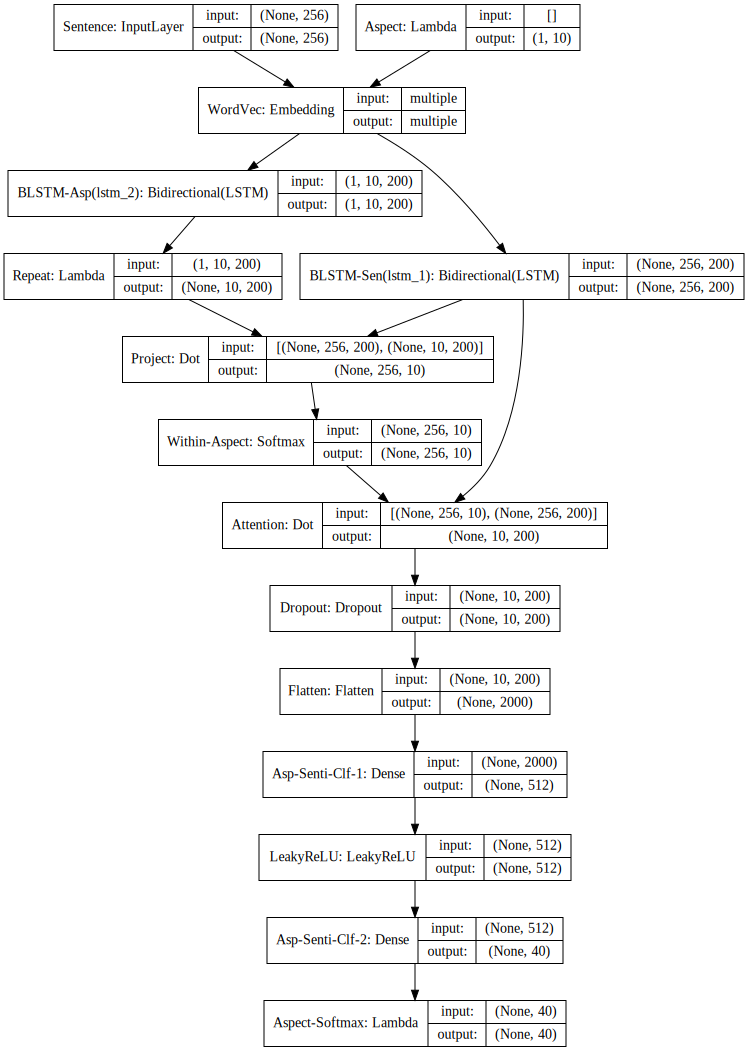

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 2.2 Custom loss & metrics

In [0]:
def reshape_senti(y):
    return K.reshape(y, (-1, N_SENTI))

def reshape_aspect(y):
    return K.reshape(y, (-1, N_ASPECT))

def to_class_label(y):
    """Four probabilities to most likely class."""
    return K.argmax(reshape_senti(y))

def cate_acc(y_true, y_pred):
    """Sum of cross entropy loss for all aspects."""
    y_true, y_pred = reshape_senti(y_true), reshape_senti(y_pred)
    loss = reshape_aspect(K.categorical_crossentropy(y_true, y_pred))
    return K.sum(loss, 1)

def acc(y_true, y_pred):
    """Sentiment-wise accuracy."""
    y_true, y_pred = to_class_label(y_true), to_class_label(y_pred)
    same = K.cast(K.equal(y_true, y_pred), K.floatx())
    size = K.cast(K.shape(y_true)[0], K.floatx())
    return K.sum(same) / size

def f1(y_true, y_pred):
    """Task-required F1 score."""
    y_true, y_pred = to_class_label(y_true), to_class_label(y_pred)    
    zeros = K.zeros_like(y_true)
    
    true_not_zero = K.cast(K.not_equal(y_true, zeros), K.floatx())
    true_zero = K.cast(K.equal(y_true, zeros), K.floatx())
    pred_not_zero = K.cast(K.not_equal(y_pred, zeros), K.floatx())
    pred_zero = K.cast(K.equal(y_pred, zeros), K.floatx())
    pred_not_true = K.cast(K.not_equal(y_true, y_pred), K.floatx())
    pred_true = K.cast(K.equal(y_true, y_pred), K.floatx())
    
    tp = K.sum(true_not_zero * pred_not_zero * pred_true + K.epsilon())
    fp = K.sum(true_not_zero * pred_not_zero * pred_not_true +
               true_zero * pred_not_zero + K.epsilon())
    fn = K.sum(true_not_zero * pred_zero + K.epsilon())
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2 * p * r / (p + r + K.epsilon())
    return f1

In [0]:
model.compile(loss=cate_acc, optimizer='adam', metrics=[acc, f1])

### 2.3 Train

In [0]:
checkpointer = ModelCheckpoint('/gdrive/My Drive/weights.hdf5', 'val_f1',
                               mode='max', verbose=1, save_best_only=True,
                               save_weights_only=True)
earlystopper = EarlyStopping(patience=10, verbose=1)
lrreducer = ReduceLROnPlateau(factor=0.65, patience=3, verbose=1)

In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer, earlystopper, lrreducer])

### 2.4 Test

In [14]:
model.load_weights('/gdrive/My Drive/weights.hdf5')
model.evaluate(X_test, y_test)

1065/1065 [==============================] - 9s 9ms/step


[1.852036397333996, 0.9440375577675905, 0.7302211085955302]

## 3 Predict & Submit

In [0]:
def submission_data():
    """Format submission data to model input style."""
    ids, X = [], []
    for e in pd.read_csv('test_public.csv').itertuples():
        ids += [e.content_id] * N_ASPECT
        X.append(preprocess(e.content))
    return ids, pad_sequences(X, maxlen=Tx)

ids, X = submission_data()

In [16]:
pred = model.predict(X, verbose=1)

2753/2753 [==============================] - 22s 8ms/step


In [0]:
def for_submission():
    """Format model output to submission style."""
    senti_id_label = {v: str(k) for k, v in senti_label_id.items()}
    aspect_id_label = {v: k for k, v in aspect_label_id.items()}
    prediction = pred.reshape(-1, N_SENTI)
    submit = 'content_id,subject,sentiment_value,sentiment_word\n'
    a = -1
    for ID, p in zip(ids, prediction):
        a = (a + 1) % N_ASPECT
        if a == 0:
            no_label = True
            lowest_0 = {'p': 1, 'i': 0}
        
        a_label = aspect_id_label[a]
        s = np.argmax(p)
        if s != 0:
            no_label = False
            submit += ID + ',' + a_label + ',' + senti_id_label[s] + ',\n'
        else:
            if p[0] < lowest_0['p']:
                lowest_0['p'] = p[0]
                lowest_0['i'] = np.argmax(p[1:]) + 1            
        
        # Post processing. At least one sentiment for each sentence.
        if a == 9 and no_label:
            submit += ID+','+a_label+','+senti_id_label[lowest_0['i']]+',\n'
            
    return submit

print(for_submission())